<a href="https://colab.research.google.com/github/fxr1115/Learning/blob/main/deep-learning-pytorch/7_recurrent-neural-networks/6_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 长短期记忆网络（LSTM）

长短期记忆网络
- 忘记门：将值朝0减少
- 输入门：决定不是忽略掉输入数据
- 输出门：决定是不是使用隐状态

**门**
$$I_t = \sigma(X_t W_{xi} + H_{t-1} W_{hi} + b_i)$$
$$F_t = \sigma(X_t W_{xf} + H_{t-1} W_{hf} + b_f)$$
$$O_t = \sigma(X_t W_{xo} + H_{t-1} W_{ho} + b_o)$$

**候选记忆单元**
$$\tilde{C}_t = \tanh(X_t W_{xc} + H_{t-1}) W_{hc} + b_c)$$

**记忆单元**
$$C_t = F_t \odot C_{t-1} + I_t \odot \tilde{C}_t$$
- 输入门$I_t$控制采用多少来自$\tilde{C}_t$的新数据
- 而遗忘门$F_t$控制保留多少过去的记忆元$C_{t-1}$的内容

**隐状态**
$$H_t = O_t \odot \tanh(\tilde{C}_t)$$
- $H_t$的值始终保持在(-1, 1)内
- 只要输出门接近1，就能够有效将所有记忆信息传递给预测部分
- 而对于输出门接近0，只保留记忆元内的所有信息，而不需要更新隐状态

**总结**
- LSTM的隐藏层输出包括‘隐状态’和‘记忆元’，只有隐状态会传递到输出层，而记忆元全属于内部信息
- LSTM可以缓解梯度消失和梯度爆炸

## 从0开始实现

In [ ]:
!pip install d2l

In [ ]:
import math
import torch
import re
import random

from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

#### 补充之前的代码

In [ ]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
  with open(d2l.download('time_machine'), 'r') as f:
    lines = f.readlines()
  return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]


def load_corpus_time_machine(max_tokens=-1):
  lines = read_time_machine()
  tokens = d2l.tokenize(lines, 'char')
  vocab = d2l.Vocab(tokens)
  corpus = [vocab[token] for line in tokens for token in line]
  if max_tokens > 0:
    corpus = corpus[:max_tokens]
  return corpus, vocab


def seq_data_iter_random(corpus, batch_size, num_steps):
  corpus = corpus[random.randint(0, num_steps - 1):]  # 随机偏移位置
  num_subseqs = (len(corpus) - 1) // num_steps  # 子序列的数目
  # 子序列起始位置的索引列表
  initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
  # 打乱
  random.shuffle(initial_indices)
  # 提取从pos开始的子序列
  def data(pos):
    return corpus[pos: pos + num_steps]
  num_batches = num_subseqs // batch_size
  for i in range(0, batch_size * num_batches, batch_size):
    inital_indices_per_batch = initial_indices[i: i + batch_size]  # 已经打乱过了
    X = [data(j) for j in inital_indices_per_batch]
    # Y是与X对齐的目标子序列，向后偏移一个时间步（预测下一个字符）
    Y = [data(j + 1) for j in inital_indices_per_batch]
    yield torch.tensor(X), torch.tensor(Y)


def seq_data_iter_sequential(corpus, batch_size, num_steps):
  offset = random.randint(0, num_steps)
  # 是batch_size的整数倍
  num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
  # 截取有效的输入序列和目标序列
  Xs = torch.tensor(corpus[offset: offset + num_tokens])
  Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
  # 重塑为批量形式
  Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
  num_batches = Xs.shape[1] // num_steps
  for i in range(0, num_steps * num_batches, num_steps):  # 序列长度不够，则要分割
    X = Xs[:, i: i + num_steps]
    Y = Ys[:, i: i + num_steps]
    yield X, Y


class seqDataLoader:
  def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
    if use_random_iter:
      self.data_iter_fn = seq_data_iter_random
    else:
      self.data_iter_fn = seq_data_iter_sequential
    self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
    self.batch_size, self.num_steps = batch_size, num_steps

  def __iter__(self):
    return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
  data_iter = seqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
  return data_iter, data_iter.vocab

class RNNModelScratch:
  def __init__(
    self, vocab_size, num_hiddens, device,
    get_params, init_state, forward_fn
  ):
    self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
    self.params = get_params(vocab_size, num_hiddens, device)
    self.init_state, self.forward_fn = init_state, forward_fn

  def __call__(self, X, state):
    X = F.one_hot(X.T, self.vocab_size).type(torch.float32)  # 将时间放在第一维
    return self.forward_fn(X, state, self.params)

  def begin_state(self, batch_size, device):
    return self.init_state(batch_size, self.num_hiddens, device)


class RNNModel(nn.Module):
  def __init__(self, rnn_layer, vocab_size, *kwargs):
    super().__init__()
    self.rnn = rnn_layer
    self.vocab_size = vocab_size
    self.num_hiddens = self.rnn.hidden_size
    # 如果RNN是双向的，num_directions应该是2，否则是1
    if not self.rnn.bidirectional:
      self.num_directions = 1
      self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
    else:
      self.num_hiddens = 2
      self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

  def forward(self, inputs, state):
    X = F.one_hot(inputs.T.long(), self.vocab_size)
    X = X.to(torch.float32)
    # Y的形状是(时间步数，批量大小，隐藏单元数)
    Y, state = self.rnn(X, state)  #不太对吧# inputs(X)的形状(seq_len, batch_size, vocab_size)
    # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
    # 它的输出形状是(时间步数*批量大小,词表大小)
    output = self.linear(Y.reshape(-1, Y.shape[-1]))
    return output, state

  def begin_state(self, device, batch_size=1):
    if not isinstance(self.rnn, nn.LSTM):
      # nn.GRU以张量作为隐状态
      return torch.zeros((
        self.num_directions * self.rnn.num_layers,
        batch_size, self.num_hiddens
        ), device=device
      )
    else:
      # nn.LSTM以元组作为隐状态
      return (
        torch.zeros((
          self.num_directions * self.rnn.num_layers,
          batch_size, self.num_hiddens
          ), device=device
        ),
        torch.zeros((
          self.num_directions * self.rnn.num_layers,
          batch_size, self.num_hiddens
          ), device=device)
        )


def clipping_grad(net, theta):
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params
  norm = torch.sqrt(sum(torch.sum(p.grad ** 2) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= (theta / norm)


def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter=False):
  state, timer = None, d2l.Timer()
  metric = d2l.Accumulator(2)
  for X, Y in train_iter:
    if state is None or use_random_iter:
      state = net.begin_state(batch_size=X.shape[0], device=device)  # 不写清楚的话，位置对应不上！！！
    else:
      if isinstance(net, nn.Module) and not isinstance(state, tuple):
        state.detach_()
      else:
        for s in state:
          s.detach_()
    y = Y.T.reshape(-1) # 将时间放到第一维，拉成一个向量
    X, y = X.to(device), y.to(device)
    y_hat, state = net(X, state)
    l = loss(y_hat, y.long()).mean()
    if isinstance(updater, torch.optim.Optimizer):
      updater.zero_grad()
      l.backward()
      clipping_grad(net, 1)
      updater.step()
    else:
      l.backward()
      clipping_grad(net, 1)
      updater(batch_size=1)
    metric.add(l * y.numel(), y.numel())
  # 计算困惑度
  return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def predict_ch8(prefix, num_preds, net, vocab, device):
  state = net.begin_state(batch_size=1, device=device)
  outputs = [vocab[prefix[0]]]
  get_inputs = lambda: torch.tensor(outputs[-1], device=device).reshape(-1, 1)  # 变成2维tensor
  # 预热期
  for y in prefix[1:]:
    _, state = net(get_inputs(), state)
    outputs.append(vocab[y])
  for _ in range(num_preds):
    y, state = net(get_inputs(), state)
    outputs.append(int(y.argmax(dim=1).reshape(1)))
  return ''.join([vocab.idx_to_token[i] for i in outputs])  # 转化为token


def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
               legend=['train'], xlim=[10, num_epochs])
  if isinstance(net, nn.Module):
    updater = torch.optim.SGD(net.parameters(), lr)
  else:
    # 自定义函数，参数是batch_size
    updater = lambda batch_size:d2l.sgd(net.params, lr, batch_size)
  predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
  for epoch in range(num_epochs):
    ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
    if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
  print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
  print(predict('time traveller'))
  print(predict('traveller'))

#### 继续

In [ ]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

### 初始化模型参数

In [ ]:
def get_lstm_params(vocab_size, num_hiddens, device):
  num_inputs = num_outputs = vocab_size
  def normal(shape):
    return torch.randn(size=shape, device=device) * 0.01

  def three():
    return(
      normal((num_inputs, num_hiddens)),
      normal((num_hiddens, num_hiddens)),
      torch.zeros(num_hiddens, device=device)
    )

  W_xi, W_hi, b_i = three()  # 输入门参数
  W_xf, W_hf, b_f = three()  # 遗忘门参数
  W_xo, W_ho, b_o = three()  # 输出门参数
  W_xc, W_hc, b_c = three()  # 候选记忆元参数

  W_hq = normal((num_hiddens, num_outputs))
  b_q = torch.zeros(num_outputs, device=device)

  params = [
    W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc,
    W_hc, b_c, W_hq, b_q
  ]

  for param in params:
    param.requires_grad_(True)
  return params

### 定义模型

In [ ]:
def init_lstm_state(batch_size, num_hiddens, device):
  return (
    torch.zeros((batch_size, num_hiddens), device=device),
    torch.zeros((batch_size, num_hiddens), device=device)
  )

In [ ]:
def lstm(inputs, state, params):
  [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o,
   W_xc, W_hc, b_c, W_hq, b_q] = params
  (H, C) = state
  outputs = []
  # X的形状：（批量大小，词表大小），根据时间步依次选取
  for X in inputs:
    I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
    F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
    O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
    C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
    C = F * C + I * C_tilda
    H = O * torch.tanh(C)
    Y = (H @ W_hq) + b_q  # Y的形状(batch_size, vocab_size)
    outputs.append(Y)
  return torch.cat(outputs, dim=0), (H, C)

### 训练和预测

困惑度 1.3, 19719.0 词元/秒 cuda:0
time traveller for so it will be canestedtica sighreat is whing 
traveller couns of staid which i sui it so i what is and wh


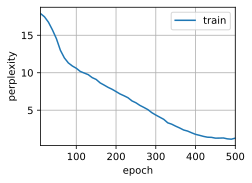

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(
  len(vocab), num_hiddens, device, get_lstm_params,
  init_lstm_state, lstm
)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 简洁实现

困惑度 1.0, 323845.4 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


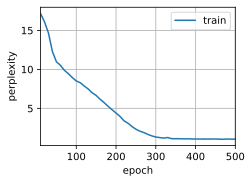

In [ ]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)